In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import itertools
import warnings
import sklearn

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Grouper
from matplotlib.pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Let's start with some better data 

In separate notebooks, we gathered the EMS, weather, and holiday data and did some initial cleaning steps. Below, we wrangle the data so it's ready for modeling. 

In [4]:
coerced_data = pd.read_csv('../data/ems_datetime_fixed.csv')

In [5]:
#drop unnecessary columns and ensure time is the index
coerced_data = coerced_data.drop(['Unnamed: 0', 'INCIDENT_DATETIME'], axis=1).set_index('proper_time')
coerced_data.index = pd.to_datetime(coerced_data.index)

One of our goals is to measure the frequency of calls over different time periods, so we need a way to tally calls when we call the "resample" method. Here we'll add a column where we assign a simple value of 1 to every call, and soon we'll use it to tally.

In [6]:
coerced_data['count'] = 1

In [7]:
coerced_data.head()

,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,ZIPCODE,POLICEPRECINCT,STANDBY_INDICATOR,Change_In_Severity,count
proper_time,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,RESPIR,4,RESPIR,4,Y,101,Y,797.0,N,82.0,BRONX,10472.0,43.0,N,0,1
2013-01-01 00:00:19,CARD,3,CARD,3,Y,59,Y,851.0,N,93.0,BRONX,10454.0,40.0,N,0,1
2013-01-01 00:01:04,ARREST,1,ARREST,1,Y,29,Y,429.0,N,83.0,QUEENS,11418.0,102.0,N,0,1
2013-01-01 00:01:16,SICK,6,SICK,6,Y,56,Y,828.0,N,82.0,BRONX,10453.0,46.0,N,0,1
2013-01-01 00:01:26,INJURY,5,INJURY,5,Y,32,Y,856.0,N,82.0,BRONX,10457.0,48.0,N,0,1


Now that the EMS data looks good, let's add in some weather data. 

In [9]:
weather_data = pd.read_csv('../data/weather_data.csv')

In [10]:
weather_data.set_index('Date', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

In [11]:
weather_data.head()

,Max Temp,Min Temp,Avg Temp,Precipitation Water Equiv,Snowfall,Snow/Ice Depth
Date,,,,,,
2013-01-01,40,26.0,33.0,0.0,0.0,0.0
2013-01-02,33,22.0,27.5,0.0,0.0,0.0
2013-01-03,32,24.0,28.0,0.0,0.0,0.0
2013-01-04,37,30.0,33.5,0.0,0.0,0.0
2013-01-05,42,32.0,37.0,0.0,0.0,0.0


And let's add in some holiday data. 

In [12]:
holiday_data = pd.read_csv('../data/holiday_data.csv')

In [13]:
holiday_data.set_index('Date', inplace=True)
holiday_data.index = pd.to_datetime(holiday_data.index)

In [14]:
holiday_data.head()

,Holiday
Date,
2013-01-01,True
2013-01-02,False
2013-01-03,False
2013-01-04,False
2013-01-05,False


Resample all data so we see metrics grouped by week. For EMS data, we want the average response time per week and the total number of calls per week. For the weather data, we want the average weekly temperature, as well as the total rainfall and snowfall per week. Lastly, for the holiday data, we want the total number of holidays per week. 

In [17]:
weekly_call_volume = coerced_data['count'].resample('W').sum()
weekly_average_response_time = coerced_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('W').mean()

#modify our avearge response time data to measure time in minutes instead of seconds
weekly_average_response_time = weekly_average_response_time / 60

In [18]:
weekly_average_temperature_data = pd.DataFrame(weather_data['Avg Temp'].resample('W').mean())
weekly_sum_precipitation = pd.DataFrame(weather_data['Precipitation Water Equiv'].resample('W').sum())
weekly_sum_snowfall = pd.DataFrame(weather_data['Snowfall'].resample('W').sum())

In [19]:
weekly_sum_holidays = holiday_data.resample('W').sum()

Create a DataFrame to merge average response time data with holiday and weather data.

In [20]:
weekly_average_response_time_df = pd.DataFrame(data=weekly_average_response_time, index=weekly_average_response_time.index)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_average_temperature_data, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_precipitation, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_snowfall, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_holidays, left_index=True, right_index=True)

#rename the columns so they are easier to understand and reference
weekly_average_response_time_df.columns = ['avg_response_time_min', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [21]:
weekly_average_response_time_df.head()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,11.203026,33.166667,0.0001,0.001,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2013-01-20,9.846154,38.428571,0.9000,0.001,0.0
2013-01-27,8.906825,21.071429,0.0701,1.501,1.0
2013-02-03,9.237061,35.428571,1.2600,0.401,0.0


Create a DataFrame to merge average call volume data with holiday and weather data.

In [22]:
weekly_call_volume_df = pd.DataFrame(data=weekly_call_volume, index=weekly_call_volume.index)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_average_temperature_data, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_precipitation, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_snowfall, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_holidays, left_index=True, right_index=True)

#rename the columns so they are easier to understand and reference
weekly_call_volume_df.columns = ['sum of weekly calls', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [23]:
weekly_call_volume_df.head()

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,23449,33.166667,0.0001,0.001,1.0
2013-01-13,27193,43.214286,0.5700,0.000,0.0
2013-01-20,25044,38.428571,0.9000,0.001,0.0
2013-01-27,23313,21.071429,0.0701,1.501,1.0
2013-02-03,24656,35.428571,1.2600,0.401,0.0


## EDA and Stationarity Check 

We wanted to see if there were any noticeable trends, so we explored the data through visualizations. Additionally, stationarity is a key assumption for time series models, so we used the Dickey-Fuller test statistic to test for stationarity. 

### Dickey-Fuller Tests:

In [24]:
#create function to perform Dickey-Fuller test and print key statistics
def dickey_fuller(ser):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ser.values)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

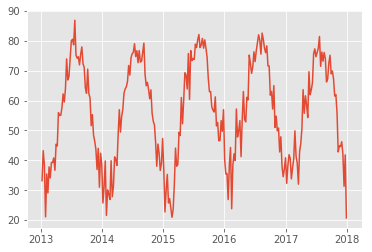

Results of Dickey-Fuller Test:
Test Statistic                -7.373287e+00
p-value                        8.855958e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [29]:
#EDA and Dickey-Fuller for weekly average temperature 
plt.plot(weekly_average_response_time_df['avg_temp'])
plt.show()
dickey_fuller(weekly_average_response_time_df['avg_temp'])

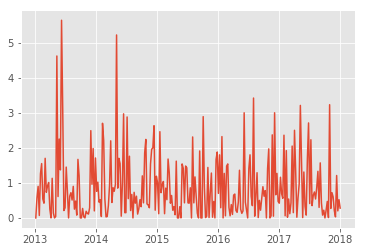

Results of Dickey-Fuller Test:
Test Statistic                -1.654803e+01
p-value                        1.956570e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64


In [30]:
#EDA and Dickey-Fuller for total weekly precipitation  
plt.plot(weekly_average_response_time_df['total_precip'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_precip'])

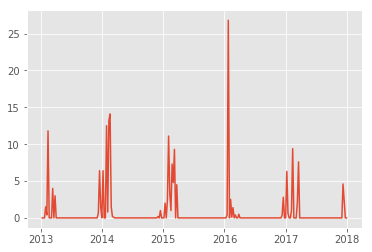

Results of Dickey-Fuller Test:
Test Statistic                -6.801037e+00
p-value                        2.236803e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


In [31]:
#EDA and Dickey-Fuller for total weekly snowfall  
plt.plot(weekly_average_response_time_df['total_snowfall'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_snowfall'])

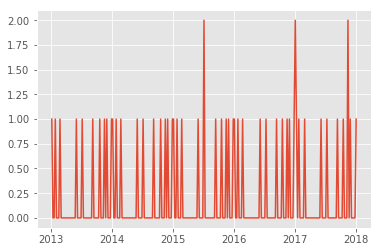

Results of Dickey-Fuller Test:
Test Statistic                  -4.678656
p-value                          0.000092
#Lags Used                      13.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [32]:
#EDA and Dickey-Fuller for total number of holidays in a week 
plt.plot(weekly_average_response_time_df['total_holidays'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_holidays'])

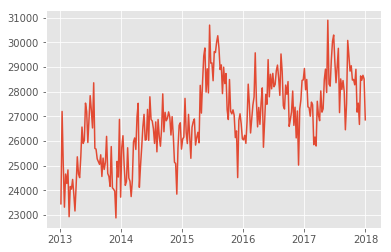

Results of Dickey-Fuller Test:
Test Statistic                  -2.774700
p-value                          0.061980
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


In [33]:
#EDA and Dickey-Fuller for total number of calls in a week 
plt.plot(weekly_call_volume)
plt.show()
dickey_fuller(weekly_call_volume)

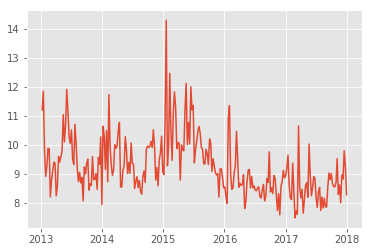

Results of Dickey-Fuller Test:
Test Statistic                  -3.759599
p-value                          0.003349
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


In [34]:
#EDA and Dickey-Fuller for weekly average response time 
plt.plot(weekly_average_response_time)
plt.show()
dickey_fuller(weekly_average_response_time)

At first glance, we get a decent P-val for our stationarity check on the total number of calls in a week and the weekly average response time, but we know we can do better. There must be seasonality to our data.

### Seasonality and Trends

EMS Response time:

<Figure size 432x288 with 0 Axes>

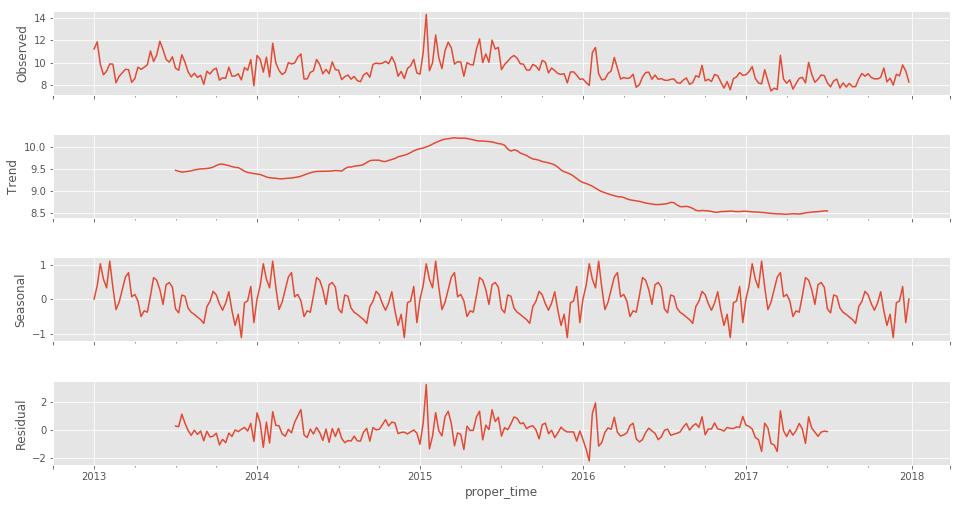

In [35]:
#seasonal decomposition for weekly average response time 
decomposition = seasonal_decompose(weekly_average_response_time, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Call Volume:

<Figure size 432x288 with 0 Axes>

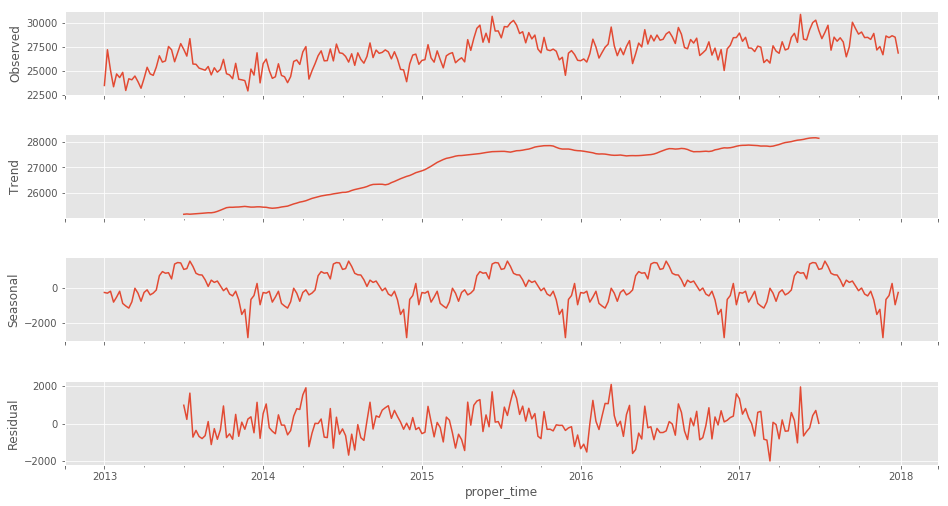

In [36]:
#seasonal decomposition for total number of calls in a week 
decomposition = seasonal_decompose(weekly_call_volume, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Seasonal First-Differencing:

EMS Response Time:

In [39]:
#for average response time, found seasonal first difference to produce best results
response_time_first_diff = weekly_average_response_time - weekly_average_response_time.shift(1)
response_time_seasonal_first_difference = (response_time_first_diff - response_time_first_diff.shift(52)).dropna()
dickey_fuller(response_time_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -1.025001e+01
p-value                        4.511493e-18
#Lags Used                     5.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (1%)           -3.463144e+00
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
dtype: float64


EMS Call Volume:

In [43]:
#for call volume, found seasonal first difference to produce best results
call_volume_first_diff = weekly_call_volume - weekly_call_volume.shift(1)
call_volume_seasonal_first_difference = (call_volume_first_diff - call_volume_first_diff.shift(52)).dropna()
dickey_fuller(call_volume_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -6.390973e+00
p-value                        2.106404e-08
#Lags Used                     1.100000e+01
Number of Observations Used    1.960000e+02
Critical Value (1%)           -3.464161e+00
Critical Value (5%)           -2.876402e+00
Critical Value (10%)          -2.574692e+00
dtype: float64


### Autocorrelation and Partial Autocorrelation:

EMS Response time:

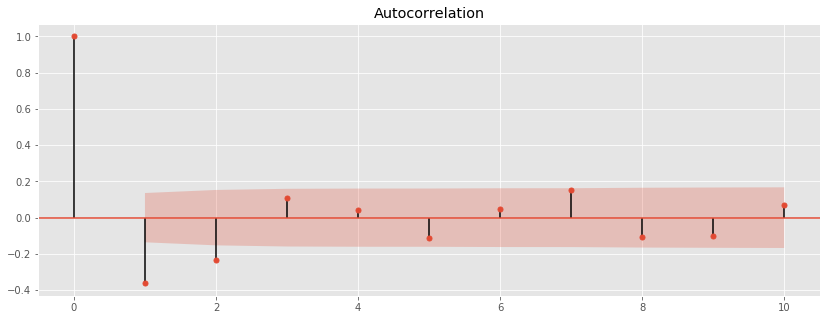

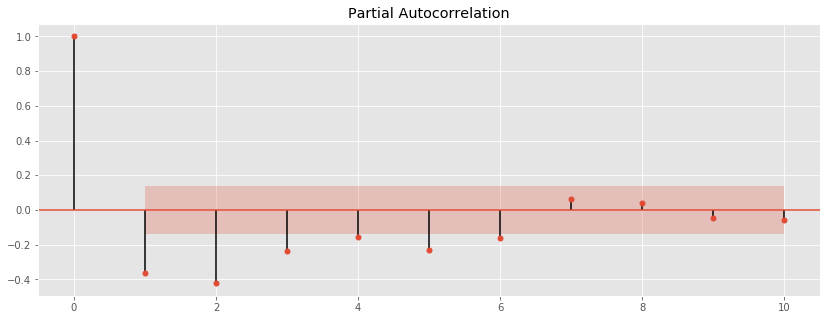

In [40]:
#ACF and PCF for average response time 
rcParams['figure.figsize'] = 14, 5
plot_acf(response_time_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(response_time_seasonal_first_difference, lags = 10);

Call Volume:

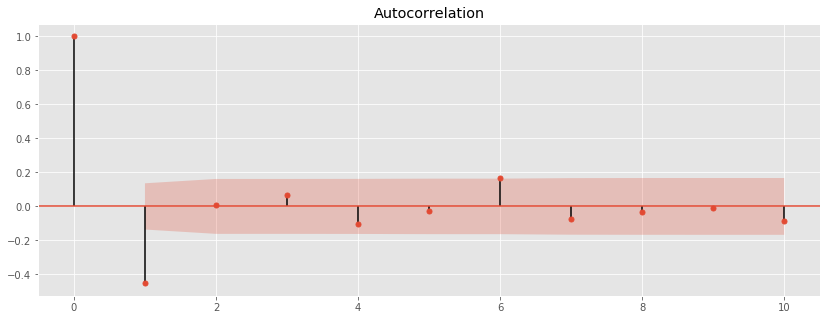

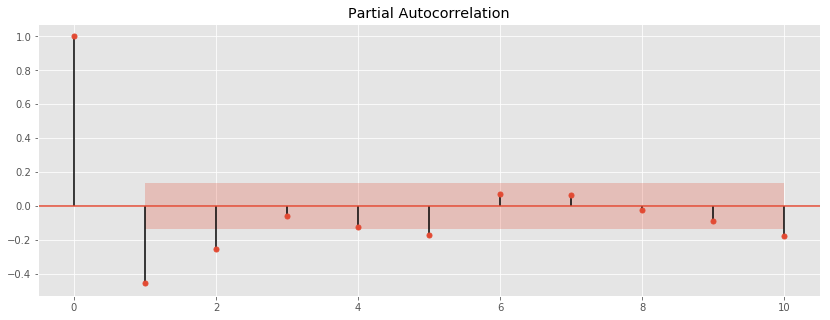

In [44]:
#ACF and PCF for call volume
rcParams['figure.figsize'] = 14, 5
plot_acf(call_volume_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(call_volume_seasonal_first_difference, lags = 10);

## Time to Model Average Response Time

Grid search for ideal parameters.

In [45]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [63]:
def arima_gs(ts):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Find the parameters with minimal AIC value.

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    print(ans_df)
    print(ans_df.loc[ans_df['aic'].idxmin()])

In [64]:
# arima_gs(weekly_average_response_time)

We decided to split our data into training and test sets with an 80-20 split.

In [46]:
endogenous_train = weekly_average_response_time[:-52]
exogenous_train = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
endogenous_test = weekly_average_response_time[-52:]
exogenous_test = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

Fit training data on SARIMAX model with optimal parameters.

In [48]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0112         -0       -inf      0.000       0.011       0.011
total_precip       0.1621         -0       -inf      0.000       0.162       0.162
total_snowfall     0.0688    6.7e-36   1.03e+34      0.000       0.069       0.069
total_holidays     0.1355   7.91e-36   1.71e+34      0.000       0.135       0.135
ar.L1              0.8762   3.51e-36    2.5e+35      0.000       0.876       0.876
ma.L1             -0.4783   3.88e-35  -1.23e+34      0.000      -0.478      -0.478
ma.S.L52        7.868e+13   4.51e-33   1.74e+46      0.000    7.87e+13    7.87e+13
sigma2          3.239e-13   1.87e-10      0.002      0.999   -3.66e-10    3.67e-10


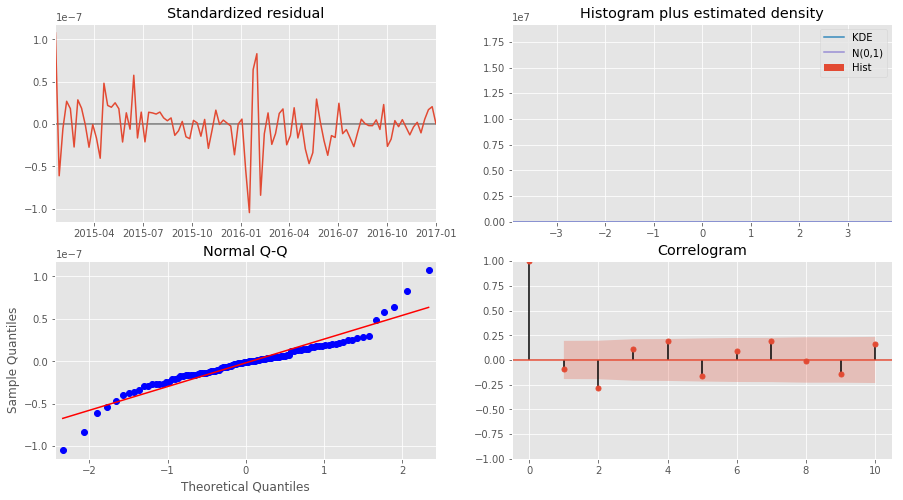

In [49]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

Generate predictions.

In [50]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

Let's see what our predictions look like against actual values. 

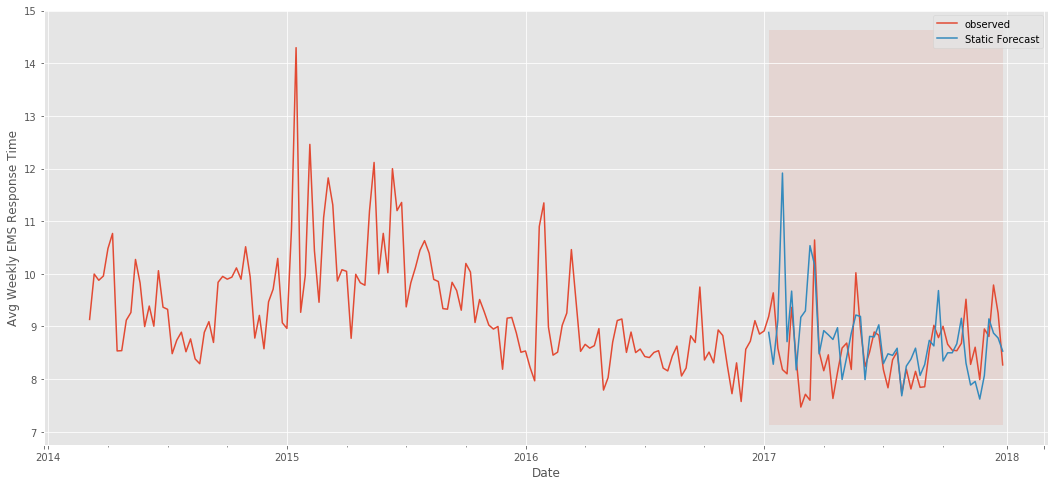

In [61]:
# Plot the static forecast with confidence intervals.

ax = weekly_average_response_time[-200:].plot(label='observed', figsize=(18, 8))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-52:-50].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly EMS Response Time')

plt.legend()
plt.show()

Let's define some error metrics. 

In [56]:
response_time_mean = np.zeros((len(weekly_average_response_time),1))
response_time_mean.fill(np.mean(weekly_average_response_time[:-52]))
response_time_mean = pd.DataFrame(response_time_mean, 
                                      index=weekly_average_response_time.index)

baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 1.1930240270839265
The RMSE when guessing the mean is 1.0922563925580506


In [94]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

print(f'''Our model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                    decimals=2)}% better than guessing the mean response time!''')

The MSE for this model is 1928712.2918200335
The RMSE for this model is 1388.780865298782
Our model does 95.06% better than guessing the mean response time!


## Now we'll do the same for Call Volume

In [66]:
endogenous_train = weekly_call_volume[:-52]
exogenous_train = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
endogenous_test = weekly_call_volume[-52:]
exogenous_test = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

In [ ]:
# arima_gs(weekly_call_volume)

Our grid search actually returned the same parameters for call volume that it did for response times, unsurprisingly. These are pretty much colinear endogenous variables.

In [67]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          86.6069         -0       -inf      0.000      86.607      86.607
total_precip     -29.8947         -0        inf      0.000     -29.895     -29.895
total_snowfall    37.3603   4.64e-37   8.04e+37      0.000      37.360      37.360
total_holidays   230.0114   7.04e-37   3.27e+38      0.000     230.011     230.011
ar.L1              0.9385   5.08e-34   1.85e+33      0.000       0.938       0.938
ma.L1             -0.4361   2.93e-32  -1.49e+31      0.000      -0.436      -0.436
ma.S.L52       -1.239e+15   2.93e-31  -4.22e+45      0.000   -1.24e+15   -1.24e+15
sigma2          3.034e-08   5.98e-09      5.070      0.000    1.86e-08    4.21e-08


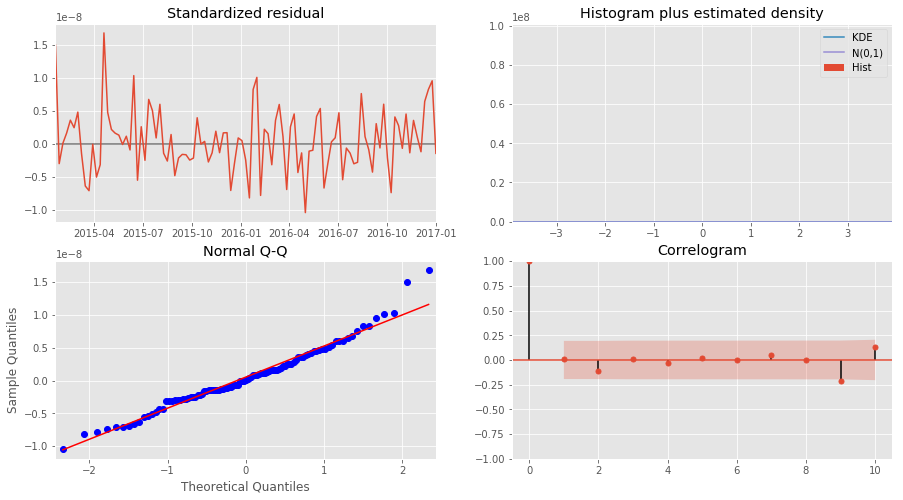

In [68]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

In [69]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

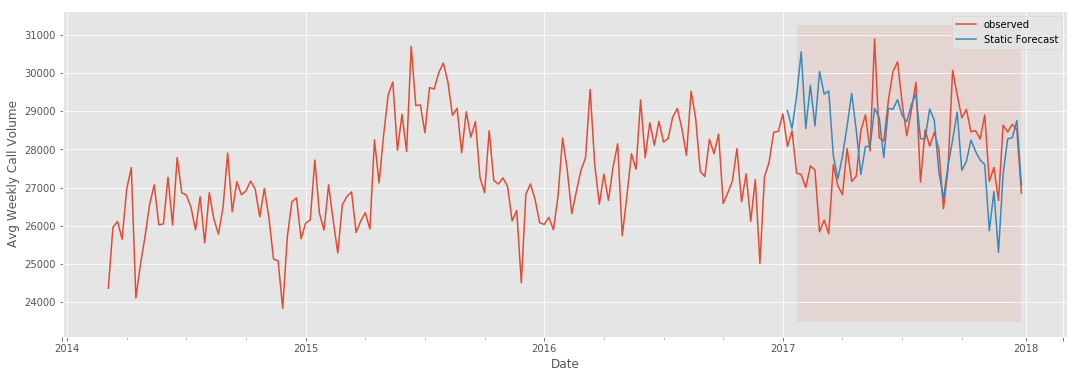

In [71]:
# Plot the static forecast with confidence intervals.

ax = weekly_call_volume[-200:].plot(label='observed', figsize=(18, 6))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-50:-49].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly Call Volume')

plt.legend()
plt.show()

In [72]:
call_vol_mean = np.zeros((len(weekly_call_volume),1))
call_vol_mean.fill(np.mean(weekly_call_volume[:-52]))
call_vol_mean = pd.DataFrame(call_vol_mean, 
                                      index=weekly_call_volume.index)

In [73]:
baseline_mse = np.mean((call_vol_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 3483004.84920789
The RMSE when guessing the mean is 1866.2810209633194


In [74]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

The MSE for this model is 1928712.2918200335
The RMSE for this model is 1388.780865298782


In [75]:
print(f'''Our model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                    decimals=2)}% better than guessing the mean call volume!''')

Our model does 25.59% better than guessing the mean call volume!


In [76]:
print(f'Our model is off by about {np.round((rmse/7),2)} calls per day on average.')
print(f'There are usually around {np.round((26908.908046/7),2)} calls per day.')

Our model is off by about 198.4 calls per day on average.
There are usually around 3844.13 calls per day.


## Vs. The Facebook's "Prophet"

In [116]:
df = pd.DataFrame(weekly_average_response_time[:-52]) # Formatting a DF how Prophet likes it
df.columns = ['y']
df['ds'] = df.index
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)

In [ ]:
forecast.index = pd.date_range(start=df.index[0], periods=len(forecast), freq='W')

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(weekly_average_response_time[-200:])
plt.plot(forecast['yhat'][-52:])
plt.show()

Error Metrics!

In [ ]:
response_time_mean = np.zeros((len(weekly_average_response_time),1))
response_time_mean.fill(np.mean(weekly_average_response_time[:-52]))
response_time_mean = pd.DataFrame(response_time_mean, 
                                      index=weekly_average_response_time.index)

baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

In [ ]:
mse = ((forecast['yhat'][-52:] - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {} \n'.format(rmse))

print(f'''This model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                    decimals=2)}% better than guessing the mean response time! Not so good.''')

## Let's explore the data more 

In [ ]:
weekly_call_volume_df.describe()

In [ ]:
weekly_average_response_time_df.describe()

In [ ]:
weekly_average_response_time_df.nlargest(10, 'avg_response_time_min')

In [ ]:
weekly_average_response_time_df.nsmallest(10, 'avg_response_time_min')

In [ ]:
weekly_call_volume_df.nlargest(10, 'sum of weekly calls')

In [ ]:
weekly_call_volume_df.nsmallest(10, 'sum of weekly calls')